In [1]:
%pip install gensim

# Classification using Word2Vec and K-Nearest Neighbors (KNN)

This notebook demonstrates text classification using:
1.  **Feature Engineering**: Word2Vec (Word Embeddings) to convert text into numerical vectors.
2.  **Classification Algorithm**: K-Nearest Neighbors (KNN).

Target Label: `Label`
Content: `Cleaned_Content`

Step 1: Loading Data...
Classes: ["Alzheimer's Disease" 'Frontotemporal Dementia' 'Lewy Body Dementia'
 "Parkinson's Disease" 'Vascular Dementia']
Step 2: Training Word2Vec & Generating Embeddings...
Feature Matrix Shape: (1641, 100)

Step 3: Training kNN...
Running 10-Fold Cross-Validation...
Mean CV Accuracy: 0.3361 (+/- 0.0338)

Step 4: Plotting Learning Curves...


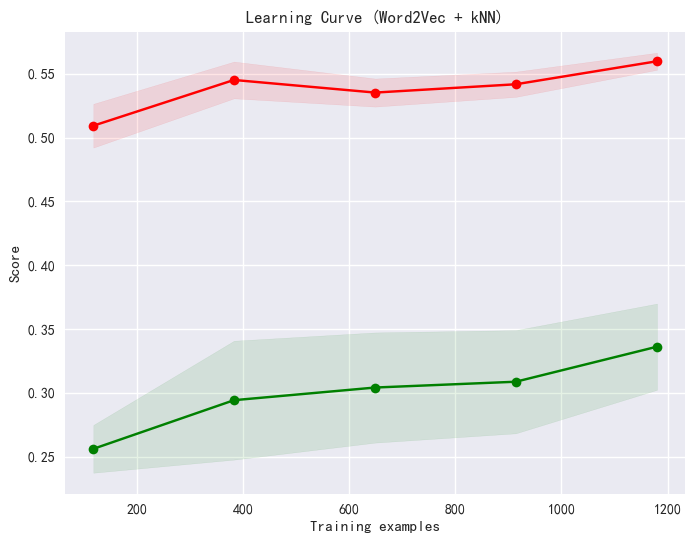


--- Classification Report ---
                         precision    recall  f1-score   support

    Alzheimer's Disease       0.31      0.41      0.36        68
Frontotemporal Dementia       0.26      0.22      0.24        59
     Lewy Body Dementia       0.34      0.30      0.32        64
    Parkinson's Disease       0.25      0.32      0.28        68
      Vascular Dementia       0.29      0.19      0.23        70

               accuracy                           0.29       329
              macro avg       0.29      0.29      0.28       329
           weighted avg       0.29      0.29      0.28       329



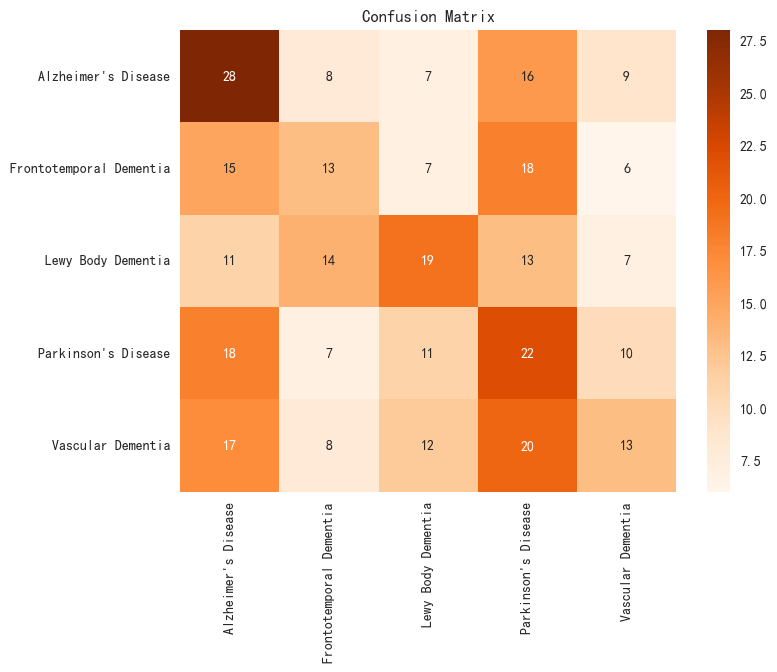

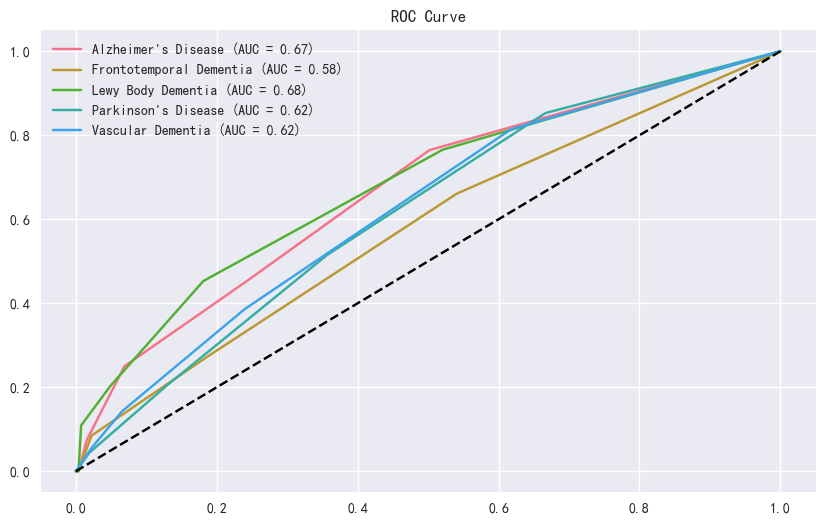


Step 6: Error Analysis...
Top Words in Errors: [('disease', np.int64(927)), ('patient', np.int64(151)), ('study', np.int64(132)), ('cognitive', np.int64(86)), ('brain', np.int64(80)), ('result', np.int64(71)), ('clinical', np.int64(69)), ('group', np.int64(64)), ('associated', np.int64(62)), ('function', np.int64(61)), ('method', np.int64(60)), ('model', np.int64(60)), ('protein', np.int64(57)), ('using', np.int64(55)), ('neurodegenerative', np.int64(54)), ('related', np.int64(52)), ('diagnosis', np.int64(51)), ('symptom', np.int64(50)), ('amyloid', np.int64(48)), ('level', np.int64(47))]

Step 7: SHAP Analysis (Embedding Dimensions)...


  0%|          | 0/20 [00:00<?, ?it/s]

SHAP Summary Plot
SHAP Analysis skipped: The shape of the shap_values matrix does not match the shape of the provided data matrix.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import shap
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# ==========================================
# 1. 数据加载与预处理
# ==========================================
print("Step 1: Loading Data...")
try:
    df = pd.read_csv('../cleaned_data.csv')
except:
    df = pd.read_csv('cleaned_data.csv')

df['Cleaned_Content'] = df['Cleaned_Content'].fillna('')
# Simple Tokenization
sentences = [text.split() for text in df['Cleaned_Content']]

le = LabelEncoder()
df['Label_Encoded'] = le.fit_transform(df['Label'])
label_names = le.classes_
print(f"Classes: {label_names}")

# ==========================================
# 2. 特征工程: Word2Vec + AvgPooling
# ==========================================
print("Step 2: Training Word2Vec & Generating Embeddings...")
# Train Word2Vec on all data (Unsupervised)
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4, seed=42)

def document_vector(doc):
    # Filter words in vocab
    doc = [word for word in doc if word in w2v_model.wv.key_to_index]
    if len(doc) == 0:
        return np.zeros(w2v_model.vector_size)
    return np.mean(w2v_model.wv[doc], axis=0)

X = np.array([document_vector(doc) for doc in sentences])
print(f"Feature Matrix Shape: {X.shape}")

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, df['Label_Encoded'], test_size=0.2, random_state=42, stratify=df['Label_Encoded']
)
# Keep raw text for Error Analysis
_, X_test_raw, _, _ = train_test_split(
    df['Cleaned_Content'], df['Label_Encoded'], test_size=0.2, random_state=42, stratify=df['Label_Encoded']
)

# ==========================================
# 3. 模型训练: kNN
# ==========================================
print("\nStep 3: Training kNN...")
knn_model = KNeighborsClassifier(n_neighbors=5, metric='cosine')

print("Running 10-Fold Cross-Validation...")
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(knn_model, X_train, y_train, cv=cv, scoring='accuracy')

print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

knn_model.fit(X_train, y_train)

# ==========================================
# 4. 学习曲线
# ==========================================
print("\nStep 4: Plotting Learning Curves...")
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.show()

plot_learning_curve(knn_model, "Learning Curve (Word2Vec + kNN)", X_train, y_train, cv=cv, n_jobs=-1)

# ==========================================
# 5. 评估与可视化
# ==========================================
y_pred = knn_model.predict(X_test)
y_prob = knn_model.predict_proba(X_test)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=label_names))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Oranges',
            xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10, 6))
y_test_bin = pd.get_dummies(y_test).values
if y_test_bin.shape[1] == len(label_names):
    for i, class_label in enumerate(label_names):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# ==========================================
# 6. 误差分析
# ==========================================
print("\nStep 6: Error Analysis...")
misclassified_indices = np.where(y_test != y_pred)[0]
# ... Standard Code ...
if len(misclassified_indices) > 0:
    error_docs = X_test_raw.iloc[misclassified_indices]
    from sklearn.feature_extraction.text import CountVectorizer
    error_cv = CountVectorizer(stop_words='english', max_features=20)
    try:
        error_counts = error_cv.fit_transform(error_docs)
        error_words = error_cv.get_feature_names_out()
        error_word_freq = np.asarray(error_counts.sum(axis=0)).flatten()
        print(f"Top Words in Errors: {sorted(dict(zip(error_words, error_word_freq)).items(), key=lambda x: x[1], reverse=True)}")
    except: pass
else:
    print("Perfect Accuracy.")

# ==========================================
# 7. 可解释性 SHAP (Embeddings)
# ==========================================
print("\nStep 7: SHAP Analysis (Embedding Dimensions)...")
try:
    # KernelExplainer for kNN
    # Use kmeans summary to approximate background distribution (faster)
    background = shap.kmeans(X_train, 10) 
    explainer = shap.KernelExplainer(knn_model.predict_proba, background)
    
    # Calculate shap values for a subset of test data
    X_shap_sample = X_test[:20]
    shap_values = explainer.shap_values(X_shap_sample)
    
    print("SHAP Summary Plot")
    # Plot for the first class
    target_idx = 0 
    shap.summary_plot(shap_values[target_idx], X_shap_sample, feature_names=[f"Dim_{i}" for i in range(X.shape[1])], show=False)
    plt.show()
except Exception as e:
    print(f"SHAP Analysis skipped: {e}")